## Tutorial on large-scale Thompson sampling

This demo currently considers:
- 10,000 points with Cholesky
- 50,000 points with Random Fourier features (RFFs)
- 50,000 points with contour integral quadrature (CIQ)

Using CIQ requires KeOps (https://github.com/getkeops/keops) and a GPU since we can't fit the corresponding covariance matrix in memory.

In [1]:
import warnings

import matplotlib.pyplot as plt
import torch
from botorch.fit import fit_gpytorch_model
from botorch.generation import MaxPosteriorSampling
from botorch.models import FixedNoiseGP, SingleTaskGP
from botorch.test_functions import Hartmann
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch
import gpytorch.settings as gpts
import pykeops
from gpytorch.constraints import Interval
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import MaternKernel, RFFKernel, ScaleKernel
from gpytorch.kernels.keops import MaternKernel as KMaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior
from gpytorch.priors.torch_priors import GammaPrior

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [12]:
pykeops.test_torch_bindings()  # Make sure the KeOps bindings are working


pyKeOps with torch bindings is working!



In [3]:
hart6 = Hartmann(dim=6, negate=True).to(device=device, dtype=dtype)
dim = hart6.dim


def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return hart6(unnormalize(x, hart6.bounds))

In [4]:
def get_initial_points(dim, n_pts, seeed=None):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

In [5]:
def generate_batch(
    X,
    Y,
    batch_size,
    n_candidates,
    sampler="cholesky",  # "cholesky", "ciq", "rff"
    use_keops=False,
):
    assert sampler in ("cholesky", "ciq", "rff")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    
    # NOTE: We probably want to pass in the default priors in SingleTaskGP here later
    kernel_kwargs = {
        "nu": 2.5,
        "ard_num_dims": X.shape[-1], 
        "lengthscale_constraint": Interval(0.05, 4.0)
    }
    if sampler == "rff":
        base_kernel = RFFKernel(**kernel_kwargs, num_samples=1024)
    else:
        base_kernel = KMaternKernel(**kernel_kwargs) if use_keops else MaternKernel(**kernel_kwargs)
    covar_module = ScaleKernel(base_kernel, outputscale_constraint=Interval(0.01, 100.0))
    
    # Fit a GP model
    train_Y = (Y - Y.mean()) / Y.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X, train_Y, likelihood=likelihood, covar_module=covar_module)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    
    # Candidates
    sobol = SobolEngine(X.shape[-1], scramble=True)
    X_cand = sobol.draw(n_candidates).to(dtype=dtype, device=device)
    
    # Thompson sample
    if sampler == "cholesky":
        with gpts.max_cholesky_size(float("inf")):
            thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
            X_next = thompson_sampling(X_cand, num_samples=batch_size)
    elif sampler == "ciq" or sampler == "rff":
        # NOTE: We can use MaxPosteriorSampling here once #652 is landed
        with gpytorch.settings.max_cholesky_size(float("inf")):
            mean = model(X_cand).mean
            covar = model(X_cand).lazy_covariance_matrix
        dist = MultivariateNormal(mean, covar.add_jitter(1e-4))
        
        if sampler == "ciq":
            with gpts.ciq_samples(True), gpts.minres_tolerance(5e-3), gpts.num_contour_quadrature(15):
                with gpts.max_cholesky_size(0), gpts.max_preconditioner_size(50):
                    y_cand = dist.sample(torch.Size([batch_size])).t()
        elif sampler == "rff":
            y_cand = dist.sample(torch.Size([batch_size])).t()
                
        X_next = torch.zeros(batch_size, X.shape[-1], dtype=dtype, device=device)
        for i in range(batch_size):
            ind_max = y_cand[:, i].argmax()
            X_next[i, :] = X_cand[ind_max, :]
            y_cand[ind_max, :] = -float("inf")

    return X_next

In [6]:
def run_optimization(n_init, max_evals, batch_size, sampler, n_candidates, use_keops=False, seed=None):
    X = get_initial_points(dim, n_init, seed)
    Y = torch.tensor([eval_objective(x) for x in X], dtype=dtype, device=device).unsqueeze(-1)
    print(f"{len(X)}) Best value: {Y.max().item():.2e}")
    
    while len(X) < max_evals:
        # Create a batch
        X_next = generate_batch(
            X=X,
            Y=Y,
            batch_size=min(batch_size, max_evals - len(X)),
            n_candidates=n_candidates,
            sampler=sampler,
            use_keops=use_keops,
        )
        Y_next = torch.tensor([eval_objective(x) for x in X_next], dtype=dtype, device=device).unsqueeze(-1)

        # Append data
        X = torch.cat((X, X_next), dim=0)
        Y = torch.cat((Y, Y_next), dim=0)

        print(f"{len(X)}) Best value: {Y.max().item():.2e}")
    return X, Y

In [7]:
batch_size = 5
n_init = 10
max_evals = 60
seed = 0  # To get the same Sobol points

## Cholesky with 10,000 candidates

In [8]:
X_chol, Y_chol = run_optimization(n_init, max_evals, batch_size, "cholesky", 10000, seed=seed)

10) Best value: 1.12e+00
15) Best value: 1.12e+00
20) Best value: 1.12e+00
25) Best value: 1.76e+00
30) Best value: 2.67e+00
35) Best value: 2.93e+00
40) Best value: 3.07e+00
45) Best value: 3.07e+00
50) Best value: 3.07e+00
55) Best value: 3.08e+00
60) Best value: 3.08e+00


## RFF with 50,000 candidates

In [9]:
X_rff, Y_rff = run_optimization(n_init, max_evals, batch_size, "rff", 50000, seed=seed)

10) Best value: 1.12e+00
15) Best value: 1.12e+00
20) Best value: 1.12e+00
25) Best value: 1.12e+00
30) Best value: 1.35e+00
35) Best value: 2.30e+00
40) Best value: 2.72e+00
45) Best value: 3.13e+00
50) Best value: 3.13e+00
55) Best value: 3.14e+00
60) Best value: 3.14e+00


## CIQ with 50,000 candidates

In [10]:
X_ciq, Y_ciq = run_optimization(n_init, max_evals, batch_size, "ciq", 50000, use_keops=True, seed=seed)

10) Best value: 1.12e+00
15) Best value: 1.12e+00
20) Best value: 1.12e+00
25) Best value: 2.43e+00
30) Best value: 2.73e+00
35) Best value: 2.73e+00
40) Best value: 2.99e+00
45) Best value: 2.99e+00
50) Best value: 3.05e+00
55) Best value: 3.16e+00
60) Best value: 3.16e+00


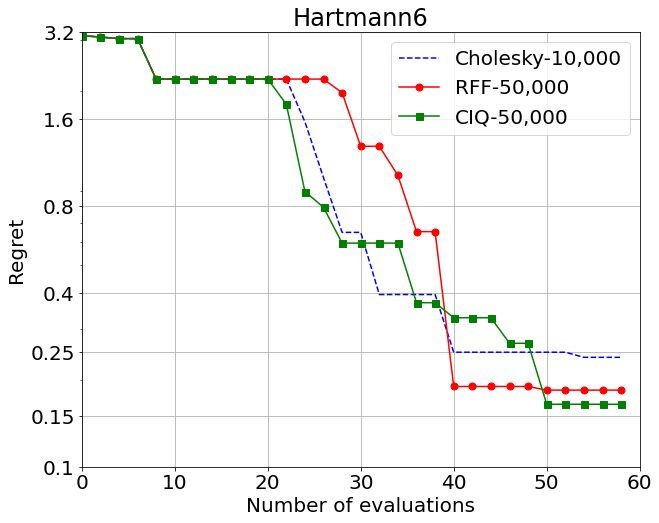

In [11]:
import matplotlib
import numpy as np
from matplotlib import rc


fig = plt.figure(figsize=(10, 8))
matplotlib.rcParams.update({"font.size": 20})

results = [
    (Y_chol.cpu(), "Cholesky-10,000", "b", "", 14, "--"),
    (Y_rff.cpu(), "RFF-50,000", "r", ".", 14, "-"),
    (Y_ciq.cpu(), "CIQ-50,000", "g", "s", 7, "-"),
]

optimum = hart6.optimal_value

ax = fig.add_subplot(1, 1, 1)
names = []
for res, name, c, m, ms, ls in results:
    names.append(name)
    regret = optimum - res.cummax(dim=0)[0]
    t = np.arange(len(regret))
    nn = int(len(t) / 30)
    plt.plot(t[0::nn], regret[0::nn], c=c, marker=m, linestyle=ls, markersize=ms)

plt.yscale("log")
plt.title("Hartmann6")
plt.ylabel("Regret")
plt.xlabel("Number of evaluations")
plt.xlim([0, max_evals])
plt.ylim([0.1, 1])
ax.set_yticks([0.1, 0.15, 0.25, 0.4, 0.8, 1.6, 3.2])
ax.set_yticklabels([0.1, 0.15, 0.25, 0.4, 0.8, 1.6, 3.2])
plt.grid(True)

plt.legend(names, loc="upper right")
plt.show()